<a href="https://colab.research.google.com/github/Taketo-Muroya/Adv-ML/blob/master/Assignment_1_for_Adv_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment #1: Write up a report on U.N. World Happiness Data**

*   Explore bivariate results (Use visualizations!)
 *   Describe any relationships you see between particular features and the target variable
*   Examine features that predict happiness categories using one or more models that allow for automatic feature selection.
 *   Explain any meaningful findings
*   Run at least three prediction models to try to predict World Happiness well.
 *   Discuss which models performed better and point out relevant hyper-parameter values for successful models.
 *   Submit your best model to the leader board for the World Happiness AI Model Share competition.


My GitHub page:
https://github.com/Taketo-Muroya/Adv-ML/blob/master/Assignment_1_for_Adv_ML.ipynb

**Loading data**

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

raw=pd.read_csv("worldhappiness2019.csv")
regiondata=pd.read_csv("region.csv")

# Merge data to get region variable
mergedata=pd.merge(raw, regiondata, how='left', left_on='Country or region', right_on='name')

# Check for missing values (there won't be any given that I have already cleaned up the region data)
mergedata.loc[pd.isnull(mergedata).iloc[:,9]].to_csv("missing.csv", index=False)

# Clean up final region data
df=mergedata.drop(['name'],axis=1)
df=df.drop(['Country or region'],axis=1)
df=df.drop(['sub-region'],axis=1)

In [2]:
# Create total variable that sums up the other variables
df['total'] = df.sum(axis=1)

df

,Happiness_level,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,region,total
0,Very High,1.340,1.587,0.986,0.596,0.153,0.393,Europe,5.055
1,Very High,1.383,1.573,0.996,0.592,0.252,0.410,Europe,5.206
2,Very High,1.488,1.582,1.028,0.603,0.271,0.341,Europe,5.313
3,Very High,1.380,1.624,1.026,0.591,0.354,0.118,Europe,5.093
4,Very High,1.396,1.522,0.999,0.557,0.322,0.298,Europe,5.094
...,...,...,...,...,...,...,...,...,...
151,Very Low,0.359,0.711,0.614,0.555,0.217,0.411,Africa,2.867
152,Very Low,0.476,0.885,0.499,0.417,0.276,0.147,Africa,2.700
153,Very Low,0.350,0.517,0.361,0.000,0.158,0.025,Asia,1.411
154,Very Low,0.026,0.000,0.105,0.225,0.235,0.035,Africa,0.626


**Data visualization**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


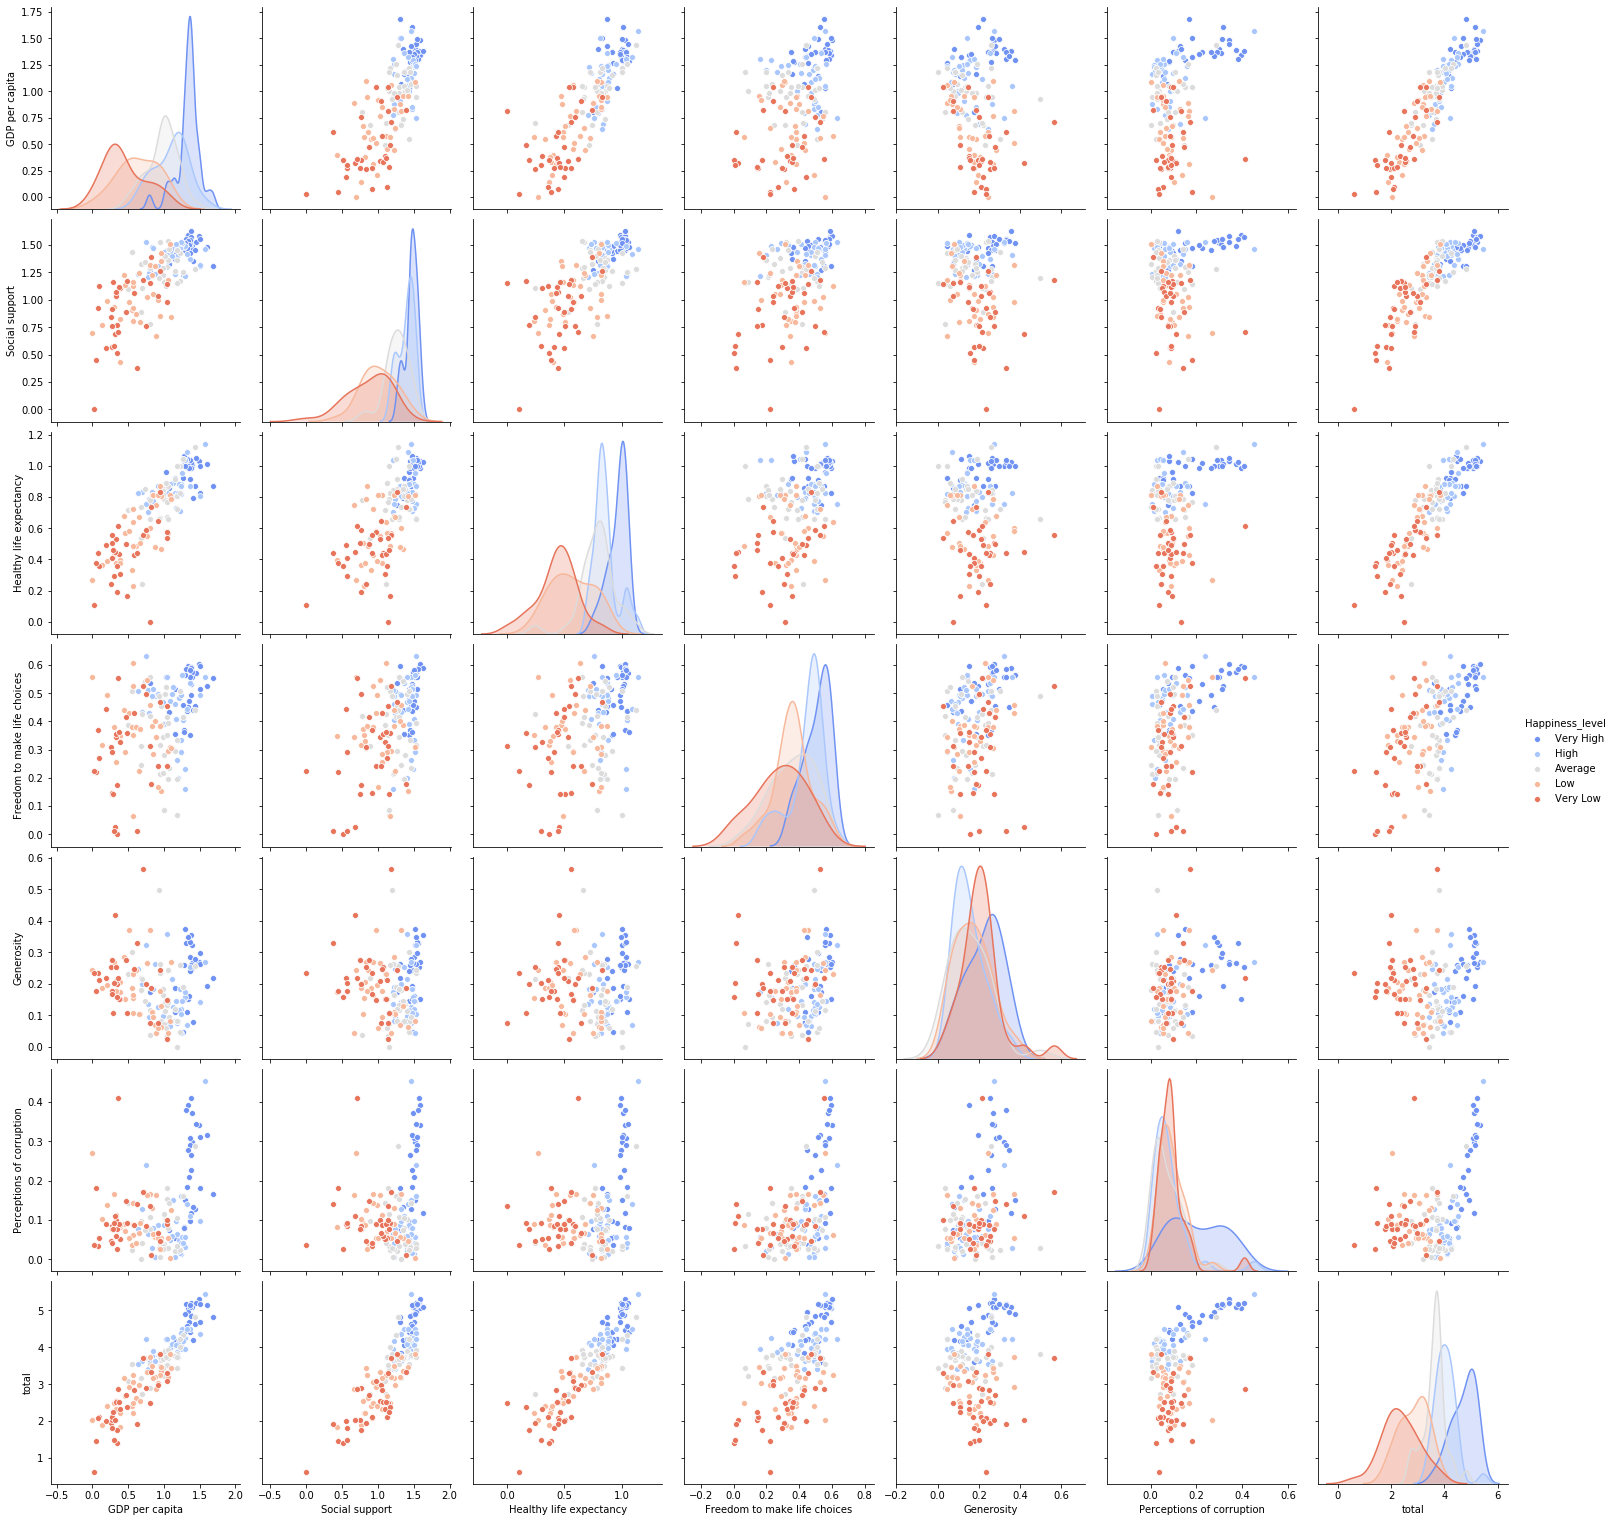

In [3]:
import seaborn as sns
sns.pairplot(df, hue='Happiness_level', size=3, palette='coolwarm')

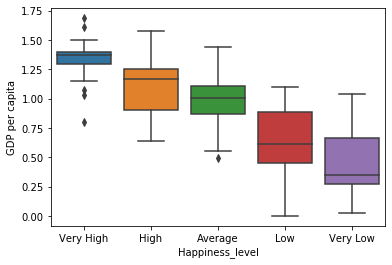

In [4]:
sns.boxplot(x = 'Happiness_level', y = 'GDP per capita', data = df)

Comment: GDP per capita seems to be associated with happiness level.

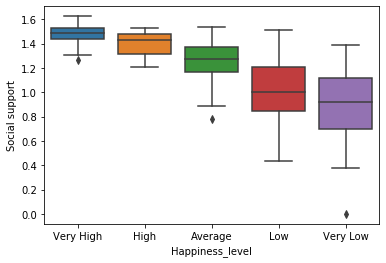

In [5]:
sns.boxplot(x = 'Happiness_level', y = 'Social support', data = df)

Comment: Social support seems to be associated with happiness level.

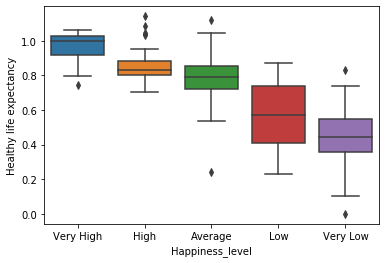

In [6]:
sns.boxplot(x = 'Happiness_level', y = 'Healthy life expectancy', data = df)

Comment: Healthy life expectancy seems to be associated with happiness level.

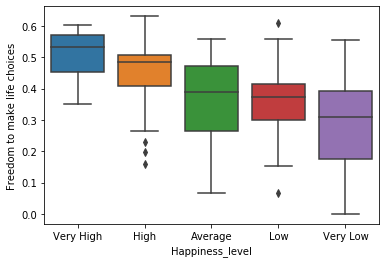

In [7]:
sns.boxplot(x = 'Happiness_level', y = 'Freedom to make life choices', data = df)

Comment: Freedom seems to be somewhat associated with happiness level.

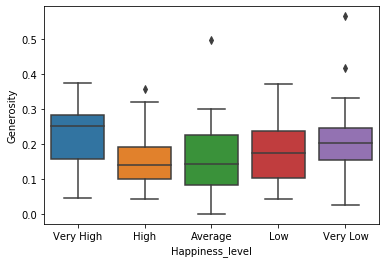

In [8]:
sns.boxplot(x = 'Happiness_level', y = 'Generosity', data = df)

Comment: Generosity does not seem to be associated with happiness level.

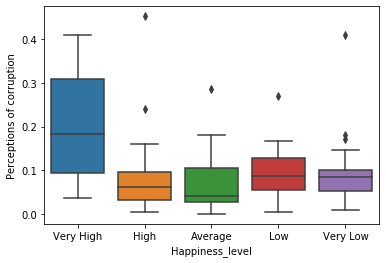

In [9]:
sns.boxplot(x = 'Happiness_level', y = 'Perceptions of corruption', data = df)

Comment: Corruption does not seem to be associated with happiness level.

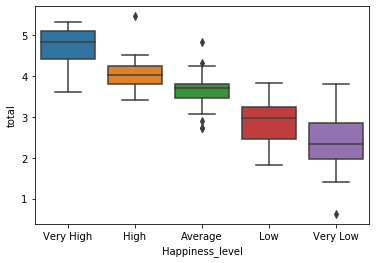

In [10]:
sns.boxplot(x = 'Happiness_level', y = 'total', data = df)

Comment: Total seems to be clearly associated with happiness level.

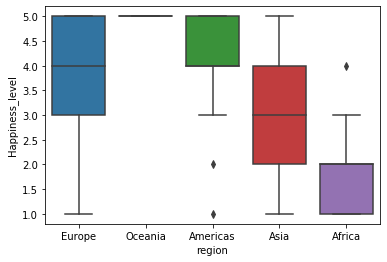

In [11]:
dictionary = {"Happiness_level": {"Very High": 5, "High": 4, "Average": 3, "Low": 2, "Very Low": 1}}
test = df.replace(dictionary)
sns.boxplot(x = 'region', y = 'Happiness_level', data = test)

Comment: Region seems to vary across happiness level.

**Preprocessing**

In [0]:
# Set up training and test data
from sklearn.model_selection import train_test_split

y=df['Happiness_level']
X=df.drop(['Happiness_level'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [0]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features=X.columns.tolist()
numeric_features.remove('region')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#Replacing missing values with Modal value and then one hot encoding.
categorical_features = ['region']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Fit your preprocessor object
prediction_input_preprocessor=preprocessor.fit(X_train) 

import pickle
pickle.dump(prediction_input_preprocessor, open( "preprocessor.pkl", "wb" ) )

In [77]:
a=pd.DataFrame(prediction_input_preprocessor.transform(X_train), 
               columns=['GDP per capita', 'Social support', 'Healthy life expectancy', 
                        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 
                        'total', 'Region1', 'Region2', 'Region3', 'Region4', 'Region5'])
a.head()

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,total,Region1,Region2,Region3,Region4,Region5
0,-0.264057,0.202017,0.044950,0.938516,-0.100025,-0.402689,0.052766,0.0,1.0,0.0,0.0,0.0
1,-0.237606,-0.195784,-2.977663,-0.525833,-1.123400,0.157965,-1.048897,1.0,0.0,0.0,0.0,0.0
2,0.748293,-0.122854,0.377195,0.760419,0.761231,-0.933836,0.454711,0.0,0.0,1.0,0.0,0.0
3,-1.346142,-1.465432,-2.199725,-1.442699,0.133021,-0.402689,-1.760409,1.0,0.0,0.0,0.0,0.0
4,1.087346,0.530203,0.551420,0.945112,0.710569,-0.087936,0.936259,0.0,0.0,1.0,0.0,0.0


In [15]:
b = pd.get_dummies(y_train)
b.head()

,Average,High,Low,Very High,Very Low
26,0,0,0,1,0
134,0,0,0,0,1
79,1,0,0,0,0
131,0,0,0,0,1
36,0,1,0,0,0


**Feature Selection**

In [78]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(solver='lbfgs')
rfe = RFE(logmodel, 1)
fit = rfe.fit(prediction_input_preprocessor.transform(X_train), y_train)

c=pd.DataFrame(fit.ranking_, index=a.columns, columns=['Contribution Ranking'])
d = c.sort_values('Contribution Ranking', ascending=True)
print(d)

                              Contribution Ranking
total                                            1
Social support                                   2
Region2                                          3
GDP per capita                                   4
Healthy life expectancy                          5
Region3                                          6
Freedom to make life choices                     7
Generosity                                       8
Region4                                          9
Region1                                         10
Perceptions of corruption                       11
Region5                                         12


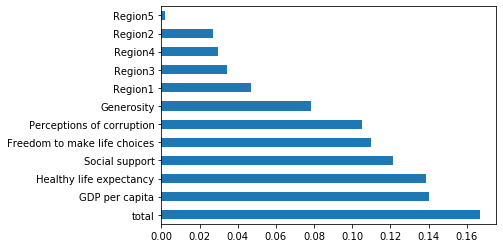

In [79]:
# Feature Importance
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train))

feat_importances = pd.Series(model.feature_importances_, index=a.columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()

Comment: "Total" seems to be the most important variable. "GDP per capita" "Healthy life expectancy" "Social support" are also important, which corresponds to what I observed in the previous graphs.

**Prediction Models**

In [0]:
# Now we can extract some evaluative metrics to use for model submission
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred, classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 
                      'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 
                      'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

m=pd.DataFrame()

**Model 1: Random Forest**

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

rfmodel = RandomForestClassifier()
rfc_param_grid = {'criterion': ['gini', 'entropy'], 
                  'n_estimators': [10, 100, 300, 500, 800, 1000]}
rfc_grid = GridSearchCV(rfmodel, rfc_param_grid, cv=10, scoring='accuracy').fit(
    prediction_input_preprocessor.transform(X_train), y_train)

print("Random Forest Classifier (GridSearchCV)")
print("best parameters: {}".format(rfc_grid.best_params_))
print("mean cross-validation score: {:.3f}".format(rfc_grid.best_score_))
print("test-set score: {:.3f}".format(rfc_grid.score(prediction_input_preprocessor.transform(X_test), y_test)))

Random Forest Classifier (GridSearchCV)
best parameters: {'criterion': 'gini', 'n_estimators': 500}
mean cross-validation score: 0.642
test-set score: 0.462


Comment: According to GridSearchCV, {'criterion': 'gini', 'n_estimators': 500} would be a best parameter set for random forest model.

In [85]:
# Make a prediction using best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

rfmodel=RandomForestClassifier(criterion='gini', n_estimators=500)
rfmodel.fit(prediction_input_preprocessor.transform(X_train), y_train)
predict_rf=rfmodel.predict(prediction_input_preprocessor.transform(X_test))

print("Support Vector Classifier's cross validation accuracy:", 
      np.mean(cross_val_score(rfmodel, prediction_input_preprocessor.transform(X_train), y_train, cv=10)))
print("Support Vector Classifier's Test-Data prediction accuracy: {:.5f}".
      format(rfmodel.score(prediction_input_preprocessor.transform(X_test), y_test)))

Support Vector Classifier's cross validation accuracy: 0.6174242424242424
Support Vector Classifier's Test-Data prediction accuracy: 0.51282


In [86]:
# add metrics to submittable object
m1=model_eval_metrics(y_test, predict_rf, classification="TRUE")
m1.index=['Random Forest']
m=m.append(m1)
m

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
Random Forest,0.512821,0.517494,0.604762,0.530556,0,0,0,0


In [0]:
# Save sklearn modle to pkl file
import pickle
pickle.dump(rfmodel, open( "rf_model.pkl", "wb" ) )

**Model 2: Support Vector Machine**

In [88]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

svmodel = SVC()
svm_param_grid = {'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10, 50, 100, 1000, 2000], 
                  'gamma': [0.0001, 0.001, 0.01, 0.1, 5, 10, 30, 50, 75, 100]}
svm_grid = GridSearchCV(svmodel, svm_param_grid, cv=10, scoring='accuracy').fit(
    prediction_input_preprocessor.transform(X_train), y_train)

print("Support Vector Classifier (GridSearchCV)")
print("best parameters: {}".format(svm_grid.best_params_))
print("mean cross-validation score: {:.3f}".format(svm_grid.best_score_))
print("test-set score: {:.3f}".format(svm_grid.score(
    prediction_input_preprocessor.transform(X_test), y_test)))

Support Vector Classifier (GridSearchCV)
best parameters: {'C': 1000, 'gamma': 0.001}
mean cross-validation score: 0.617
test-set score: 0.487


Comment: According to GridSearchCV, {'C': 1000, 'gamma': 0.001} would be a best parameter set for support vector model.

In [89]:
# Make a prediction using best parameters
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

svmodel=SVC(C=1000, gamma=0.001)
svmodel.fit(prediction_input_preprocessor.transform(X_train), y_train)
predict_sv=svmodel.predict(prediction_input_preprocessor.transform(X_test))

print("Support Vector Classifier's cross validation accuracy:", 
      np.mean(cross_val_score(svmodel, prediction_input_preprocessor.transform(X_train), y_train, cv=10)))
print("Support Vector Classifier's Test-Data prediction accuracy: {:.5f}".
      format(svmodel.score(prediction_input_preprocessor.transform(X_test), y_test)))

Support Vector Classifier's cross validation accuracy: 0.6166666666666667
Support Vector Classifier's Test-Data prediction accuracy: 0.48718


In [90]:
# add metrics to submittable object
m2=model_eval_metrics(y_test, predict_sv, classification="TRUE")
m2.index=['Support Vector']
m=m.append(m2)
m

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
Random Forest,0.512821,0.517494,0.604762,0.530556,0,0,0,0
Support Vector,0.487179,0.492914,0.561616,0.500000,0,0,0,0


In [0]:
# Save sklearn modle to pkl file
import pickle
pickle.dump(svmodel, open( "svc_model.pkl", "wb" ) )

**Model 3: Neural Network**



In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Create model function
def create_model(U1=30, U2=30):
	# Create model
	model = Sequential()
	model.add(Dense(U1, activation='relu', input_dim=12))
	model.add(Dense(U2, activation='relu'))
	model.add(Dense(5, activation='softmax'))
	# Compile model
	model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# Call model function in KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

# Implement the grid search
U1 = [10, 20, 30, 40, 50, 100]
U2 = [10, 20, 30, 40, 50, 100]
param_grid = dict(U1=U1, U2=U2)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train))

# Results
print("Best CV-score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Test score with best parameters:", 
      grid_result.score(prediction_input_preprocessor.transform(X_test), pd.get_dummies(y_test)))

Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Best CV-score: 0.591304 using {'U1': 100, 'U2': 40}
0.462681 (0.118283) with: {'U1': 10, 'U2': 10}
0.503986 (0.037028) with: {'U1': 10, 'U2': 20}
0.462681 (0.064505) with: {'U1': 10, 'U2': 30}
0.523913 (0.156903) with: {'U1': 10, 'U2': 40}
0.565580 (0.135123) with: {'U1': 10, 'U2': 50}
0.479710 (0.089122) with: {'U1': 10, 'U2': 100}
0.461957 (0.052129) with: {'U1': 20, 'U2': 10}
0.487319 (0.097692) with: {'U1': 20, 'U2': 20}
0.514493 (0.112611) with: {'U1': 20, 'U2': 30}
0.478986 (0.093767) with: {'U1': 20, 'U2': 40}
0.548913 (0.115055) with: {'U1': 20, 'U2': 50}
0.505072 (0.079027) with: {'U1': 20, 'U2': 100}
0.436594 (0.094717) with: {'U1': 30, 'U2': 10}
0.523913 (0.164723) with: {'U1': 30, 'U2': 20}
0.522464 (0.079219) with: {'U1': 30, 'U2': 30}
0.514493 (0.098268) with: {'U1': 30, 'U2': 40}
0.539855 (0.094724) with: {'U1': 30, 'U2': 50}
0.565217 (0.098188) with: {'U1': 30, 'U2

Comment: Among 6x6=36 models differentiating the number of units in two hidden layers, {'U1': 100, 'U2': 40} would be the best parameter.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

nnmodel = Sequential()
nnmodel.add(Dense(100, input_dim=12, activation='relu'))
nnmodel.add(Dense(40, activation='relu'))
nnmodel.add(Dense(5, activation='softmax'))

# Compile model
nnmodel.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
nnmodel.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train), 
            batch_size=100, epochs=500, validation_split=0.2, verbose=1)

In [0]:
# using predict_classes() for multi-class data to return predicted class index.
prediction_index=nnmodel.predict_classes(prediction_input_preprocessor.transform(X_test))
# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns
# Function to use to return label from column index location
def index_to_label(labels,index_n): 
    return labels[index_n]
# Example: return label at predicted index location 1
index_to_label(labels,1)
# Iterate through all predicted indices using map method
predict_nn=list(map(lambda x: labels[x], prediction_index))

In [93]:
# add metrics to submittable object
m3=model_eval_metrics(y_test, predict_nn, classification="TRUE")
m3.index=['Neural Network']
m=m.append(m3)
m

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
Random Forest,0.512821,0.517494,0.604762,0.530556,0,0,0,0
Support Vector,0.487179,0.492914,0.561616,0.500000,0,0,0,0
Neural Network,0.487179,0.482559,0.576623,0.511111,0,0,0,0


Comment: Rodom forest model seems to be the best model for me.

In [31]:
# Load libraries for onnx model conversion (keras to onnx)
! pip3 install keras2onnx
! pip3 install onnxruntime

In [0]:
#Convert keras model object to onnx and then save it to .onnx file
import os
if not os.path.exists('nnmodel.onnx'):
    from keras2onnx import convert_keras
    onx = convert_keras(nnmodel, 'nnmodel.onnx')
    with open("nnmodel.onnx", "wb") as f:
        f.write(onx.SerializeToString())

**Submission to AI Model Share competition**

In [33]:
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.2.tar.gz?raw=true

  Using cached https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.2.tar.gz?raw=true
  Created wheel for aimodelshare: filename=aimodelshare-0.0.2-cp36-none-any.whl size=5375 sha256=cca26a515b5c47be05e01e85028547faff465b03b01a44afb884c1129090e005
  Stored in directory: /root/.cache/pip/wheels/31/8d/ac/09cb6ef7374ec79e02843c347195e5478144006b11def6799a
Successfully built aimodelshare


In [0]:
import pickle
# Loading AWS keys necessary to submit model.  Loading to object, so we don't print them out in our notebook
aws_key_password_region = pickle.load( open( "worldhappiness_modelsubmission_keys.pkl", "rb" ) ) 

In [0]:
# Example Model Pre-launched into Model Share Site
apiurl="https://btuvanmi55.execute-api.us-east-1.amazonaws.com/prod/m"
username = "XXX"
password = "XXX"

region='us-east-1'
model_filepath="rf_model.pkl"   
preprocessor_filepath="preprocessor.pkl"
preprocessor="TRUE"

trainingdata=X_train

# Set aws keys for this project (these keys give you access to collaborate on a single project)
# Importing from object that stores keys so we do not print out keys for others to see.
aws_key_password_region = pickle.load( open( "worldhappiness_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [97]:
import aimodelshare as ai
ai.submit_model(model_filepath=model_filepath, model_eval_metrics=m1, apiurl=apiurl, username=username, 
                password=password, aws_key=aws_key, aws_password=aws_password, region=region, trainingdata=trainingdata,
                preprocessor_filepath=preprocessor_filepath, preprocessor=preprocessor)

"rf_model.pkl" has been loaded to version 96 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


In [98]:
ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region).head(50)

LEADERBOARD RANKINGS:


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression
25,0.717949,0.717857,0.717857,0.727778,0,0,0,0,3scman,85,2.333333,1.0
15,0.717949,0.713796,0.719444,0.725000,0,0,0,0,3scman,70,2.333333,1.0
7,0.666667,0.675975,0.754286,0.700952,0,0,0,0,dhoward97,69,2.666667,1.0
58,0.692308,0.693333,0.700397,0.702778,0,0,0,0,3scman,62,4.000000,1.0
62,0.641026,0.642381,0.743590,0.682273,0,0,0,0,SUN-Wenjun,83,4.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
42,0.384615,0.343861,0.348889,0.422222,0,0,0,0,zivzach,50,35.666667,1.0
66,0.384615,0.303896,0.340260,0.425000,0,0,0,0,abhay_07,18,36.666667,1.0
70,0.333333,0.337698,0.385556,0.322222,0,0,0,0,username2,2,36.000000,1.0
78,0.333333,0.337698,0.385556,0.322222,0,0,0,0,username2,3,36.000000,1.0


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression
25,0.717949,0.717857,0.717857,0.727778,0,0,0,0,3scman,85,2.333333,1.0
15,0.717949,0.713796,0.719444,0.725000,0,0,0,0,3scman,70,2.333333,1.0
7,0.666667,0.675975,0.754286,0.700952,0,0,0,0,dhoward97,69,2.666667,1.0
58,0.692308,0.693333,0.700397,0.702778,0,0,0,0,3scman,62,4.000000,1.0
62,0.641026,0.642381,0.743590,0.682273,0,0,0,0,SUN-Wenjun,83,4.000000,1.0
79,0.641026,0.646886,0.738333,0.680952,0,0,0,0,dhoward97,68,4.000000,1.0
90,0.641026,0.639160,0.660476,0.700455,0,0,0,0,SUN-Wenjun,81,6.333333,1.0
19,0.641026,0.639160,0.660476,0.700455,0,0,0,0,SUN-Wenjun,82,6.333333,1.0
41,0.615385,0.620793,0.634394,0.658636,0,0,0,0,SUN-Wenjun,79,7.666667,1.0
73,0.615385,0.620793,0.634394,0.658636,0,0,0,0,SUN-Wenjun,80,7.666667,1.0
